# Exponential Integrate-and-fire model

## Model Introduction

Exponential Integrate-and-fire model(ExpIF model) is a neuron model derive from LIF model. As presented before, LIF model is a simple model include only a differential equation and a threshold mechanism, which hardly captures any minor property. ExpIF model therefore is proposed by Fourcaud-Trocmé(2003) to approximate conductance-based models such as Wang-Buzsáki model(Wang and Buzsáki, 1996).

The differential equation of all integrate-and-fire models can be write as:

$$C_m\frac{dV}{dt} = -\frac{V-V_{rest}}{R_m} + \psi(V) + I(t)$$

In which $V$ is membrane potential, $V_{rest}$ is resting potential, $R_m$ is membrane resistance, $C_m$ is membrane capacitance, and $I(t)$ is time-dependent input current, composed of external input current and postsynaptic current.

When $V>=V_{th}$, the membrane potential will be reset to $V_{reset}$.

In LIF model, $\psi(V) = 0$ is a special condition. As for ExpIF model, we propose another threshold $V_T$:

$$\psi^{'}(V_T) = g_m = \frac{1}{R_m}$$

$V_T$ is the maximum membrane potential at which neuron can stay steady with a constant input but not fire. The corresponding threshold input $I(t) = \frac{V_T-V_{rest}}{R_m} - \psi(V_T)$ is the maximum value of constant external input, with which neuron can meet $V_T$ without fire.

Another parameter $\varDelta_T$ refers to a spike slope factor, measures the sharpness of spike initation. $\varDelta_T$ is defined as:

$$\varDelta_T = \frac{g_m}{\psi^{''}(V_T)}$$

Therefore ExpIF model is given by:

$$\psi(V) = g_m\varDelta_Te^{\frac{V-Vrest}{\varDelta_T}}$$

combine it with the general equation we get:

$$C_m\frac{dV}{dt} = -\frac{V-V_{rest}}{R_m} + g_m\varDelta_Te^{\frac{V-Vrest}{\varDelta_T}} + I(t)$$

## Model Implementation

In [1]:
import brainpy as bp

In [4]:
## define Exponential Leaky Integrate-and-Fire model
class ExpIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, t, I_ext, V_rest, delta_T, V_T, R, tau):
        dvdt = (- V + V_rest \
                + delta_T * bp.ops.exp((V - V_T) / delta_T) 
                + R * I_ext) \
               / tau
        return dvdt

    def __init__(self, size, V_rest=-65., V_reset=-68., 
                 V_th=-30., V_T=-59.9, delta_T=3.48, 
                 R=10., C=1., tau=10., t_refractory=1.7, 
                 **kwargs):
        
        # parameters
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.V_T = V_T
        self.delta_T = delta_T
        self.R = R
        self.C = C
        self.tau = tau
        self.t_refractory = t_refractory

        # variables
        self.V = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype = bool)
        self.refractory = bp.ops.zeros(size, dtype = bool)
        self.spike_cnt = bp.ops.zeros(size)
        self.t_last_spike = bp.ops.ones(size) * -1e7

        self.integral = bp.odeint(self.derivative)
        super(ExpIF, self).__init__(size = size, **kwargs)

    def update(self, _t):
        refractory = (_t - self.t_last_spike) <= self.t_refractory
        V = self.integral(self.V, _t, self.input, self.V_rest, 
                          self.delta_T, self.V_T, self.R, self.tau)
        V = bp.ops.where(refractory, self.V, V)
        spike = self.V_th <= V
        self.t_last_spike = bp.ops.where(spike, _t, 
                                             self.t_last_spike)
        self.V = bp.ops.where(spike, self.V_reset, V)
        self.refractory = refractory
        self.input[:] = 0.
        self.spike = spike

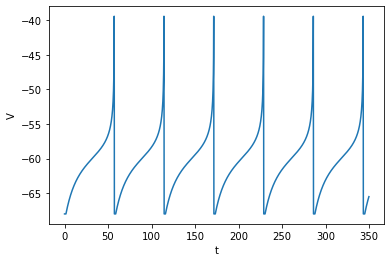

In [5]:
import numpy as np
# build neuron group
neu = ExpIF(10, monitors=['V'])
neu.V_rest = -65.
neu.tau = 10.

# create input
duration = 350.
current, pos_dur = bp.inputs.constant_current([(0.30, duration)])

# simulate
neu.run(
    duration = pos_dur, 
    inputs = ["input", current], 
    report = False)  
#simulate for 100 ms. Give external input = current

# paint
bp.visualize.line_plot(neu.mon.ts, neu.mon.V, 
                       xlabel = "t", ylabel = "V", 
                       show=True)


<img src="../../images/ExpIF-1.png">

<center>An ExpIF neuron with noisy input | BrainPy-Models</center>

## Model Analysis

### Fitting WB model

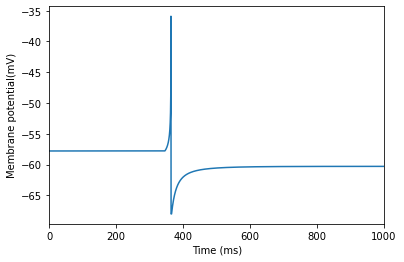

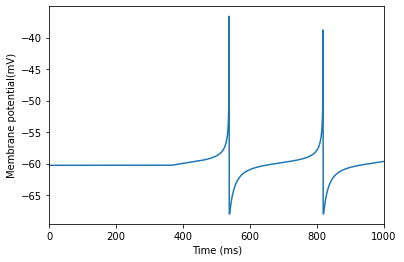

In [10]:
duration = 1000.
ExpIF_neuron = ExpIF(1, monitors = ['V'])
neu.V_rest = -65.
neu.tau = 10.

# input current = 0.16, under the threshold
current, pos_dur = bp.inputs.constant_current(
    [(0.16, duration)])
neu.run(
    duration = pos_dur, 
    inputs = ["input", current], 
    report = False)

bp.visualize.line_plot(neu.mon.ts, neu.mon.V, 
                       xlabel = "Time (ms)",
                       ylabel = "Membrane potential(mV)", 
                       xlim = [-0.1, neu.mon.ts[-1] + 0.1],
                       show=True)

#input current = 0.17, above the threshold
ExpIF_neuron = ExpIF(1, monitors = ['V'])
neu.V_rest = -65.
neu.tau = 10.

# input current = 0.16, under the threshold
current, pos_dur = bp.inputs.constant_current(
    [(0.17, duration)])
neu.run(
    duration = pos_dur, 
    inputs = ["input", current], 
    report = False)

bp.visualize.line_plot(neu.mon.ts, neu.mon.V, 
                       xlabel = "Time (ms)",
                       ylabel = "Membrane potential(mV)", 
                       xlim = [-0.1, neu.mon.ts[-1] + 0.1],
                       show=True)

Fourcaud-Trocmé (2003) proposed that ExpIF model can easily reproduce the behavior of conductance-based model. For example, with proper parameters, ExpIF model can match the f-I curve of WB model. Here we paint two figures to show how well can integrate-and-fire model fit WB model:

### Fitting WB model curve

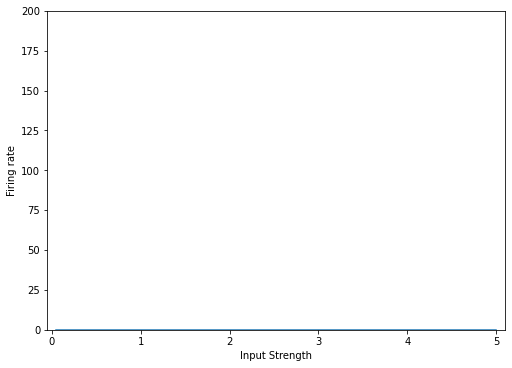

In [11]:
import matplotlib.pyplot as plt
# set params
I_ext_list = []
firing_rate_list = []

stim_start = 0
stim_end = 100
stim_step = 1
epoch = (stim_end-stim_start) / stim_step

step = 0
I_ext = 0

for i in range(stim_start, stim_end):
    # build network
    neu = ExpIF(1, monitors = ['V', 'spike_cnt'])  #create a neuron group with 10 neurons.
    neu.V_rest = -65.
    neu.tau = 10.

    #create input
    I_ext += 0.05  ##actual stim is range(0, 5, 0.05)
    current, pos_dur = bp.inputs.constant_current(
        [(I_ext, duration)])

    #simulate
    neu.run(duration = pos_dur, inputs = ["input", current])

    firing_rate = neu.mon.spike_cnt[-1, 0] * 1000/duration
    I_ext_list.append(I_ext)
    firing_rate_list.append(firing_rate)

    step += 1
    print(f"epoch {step}/{int(epoch)}, input amplitude = {I_ext}, firing rate = {firing_rate}", end = '\r', flush = True)

#paint
fig, gs = bp.visualize.get_figure(1, 1, 5, 7)
plt.plot(I_ext_list, firing_rate_list)
plt.xlabel('Input Strength')
plt.ylabel('Firing rate')
plt.xlim(I_ext_list[0]-0.1, I_ext_list[-1]+0.1)
plt.ylim(-0.1, 200)
plt.show()

<img src="../../images/ExpIF-2.png">

<center>f-I curve of integrate models and WB model | [1]</center>

Clearly, our ExpIF model match with WB model's f-I curve.

We should mention that WB model is a type I neuron, which means its firing rate at threshold is 0. Type II neurons are at odds with WB model, whose firing rate is not 0 at threshold.

## References

[1] Fourcaud-Trocmé, Nicolas, et al. "How spike generation mechanisms determine the neuronal response to fluctuating inputs." Journal of Neuroscience 23.37 (2003): 11628-11640.

[2] Wang, Xiao Jing . "Gamma Oscillation by Synaptic Inhibition in a Hippocampal Interneuronal Network Model." Journal of Neuroence 16.20(1996):6402-6413.